<h1> Evaluation of a dataset + a model</h1>

In this notebook we focus on the fairness evaluation of a couple (dataset, model). </br>
We use two libraries : dalex and aif360.

In [186]:
#! pip install -U scikit-learn
import pandas as pd
import numpy as np
from copy import copy

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [187]:
#! pip install dalex
import dalex as dx

#! pip install aif360 tensorflow
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

<h4> Load the dataset and train the model</h4>

In [112]:
# load the original dataset 
# data = pd.read_csv("https://raw.githubusercontent.com/ekimetrics/ethical-ai-toolkit/main/data/german-risk-scoring.csv")

# load a clean version of the german risk scoring dataset
data = dx.datasets.load_german()
data.head()

,risk,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age
0,1,male,2,own,not_known,little,1169,6,radio/TV,67
1,0,female,2,own,little,moderate,5951,48,radio/TV,22
2,1,male,1,own,little,not_known,2096,12,education,49
3,1,male,2,free,little,little,7882,42,furniture/equipment,45
4,0,male,2,free,little,little,4870,24,car,53


In [144]:
X = data.drop(columns='risk')
y = data.risk

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', numerical_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=7, random_state=123))
])

clf.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'job', 'housing',
                                                   'saving_accounts',
                                                   'checking_account',
                                                   'purpose']),
                                                 ('num', 'passthrough',
                                                  ['age', 'duration',
                                                   'credit_amount'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=7, random_state=123))])

<h4> Extract fairness metrics </h4>

The first step is to define the sensitive attributes on which we wish to evaluate fairness. Then, each library automatically compute a bunch of fairness metrics.
<ul>
    <li> With dalex, first wrap the "model + dataset" in an Explainer object and then apply the method model_fairness. This returns a GroupFairnessClassification object which has already computed all the mtrics and which can either give a fairness_check or a plot.</li>
    <li> With aif360, first wrap the dataset with groundtruth labels and the dataset with predicted labels in two BinaryLabelDataset objects, then wrap the "BinaryLabelDataset_groundtruth + BinaryLabelDataset_predicted" in an ClassificationMetric object. This object has several methods that compute fairness metrics.
</ul>

In [145]:
explainer = dx.Explainer(clf, X, y, verbose=False)

protected = data.sex + '_' + np.where(data.age < 25, 'young', 'old')
privileged = 'male_old'

fairness_object = explainer.model_fairness(protected = protected, privileged=privileged)

In [146]:
fairness_object.fairness_check(epsilon = 0.8)

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'male_old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                   TPR       ACC       PPV       FPR       STP
female_old    1.018828  1.000000  0.971963  0.921525  0.964677
female_young  0.981172  0.938824  0.891355  0.872197  0.855055
male_young    1.019874  0.977647  0.929907  0.896861  0.918392


In [151]:
fairness_object.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
female_old,0.974,0.589,0.832,0.915,0.026,0.411,0.168,0.085,0.850,0.792
female_young,0.938,0.611,0.763,0.880,0.062,0.389,0.237,0.120,0.798,0.702
male_old,0.956,0.554,0.856,0.821,0.044,0.446,0.144,0.179,0.850,0.821
male_young,0.975,0.600,0.796,0.938,0.025,0.400,0.204,0.062,0.831,0.754



Found NaN's or 0's for models: {'DecisionTreeClassifier'}
It is advisable to check 'metric_ratios'


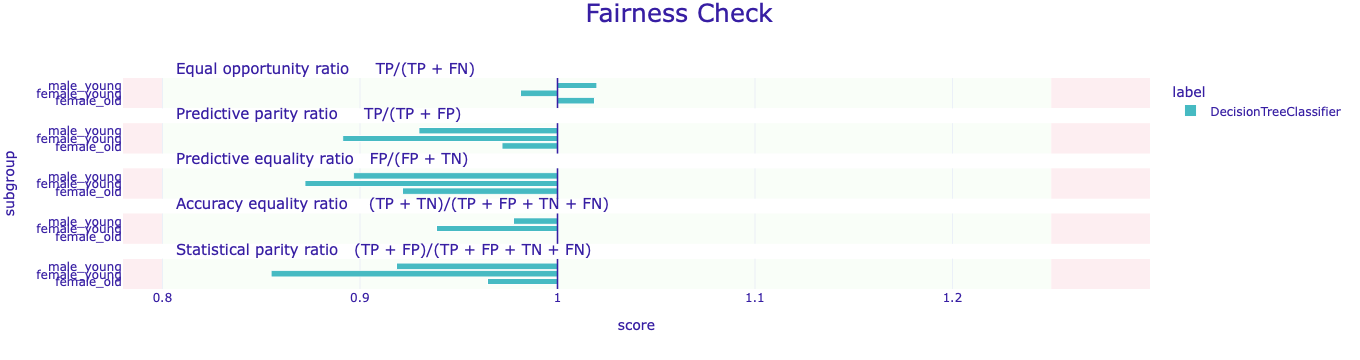

In [147]:
fairness_object.plot()

In [189]:
data.head()
data_for_aif = X[['sex']]
data_for_aif['sex'] = data_for_aif['sex'].apply(lambda x: int(x == 'male'))
data_for_aif['age'] = X['age'].apply(lambda x: int(x >= 25))

y_pred = clf.predict(X)

data_for_aif_gt = copy(data_for_aif)
data_for_aif_pred = copy(data_for_aif)
data_for_aif_gt['risk'] = y
data_for_aif_pred['risk'] = y_pred

In [204]:
binary_dataset_gt = BinaryLabelDataset(df=data_for_aif_gt, label_names=['risk'], protected_attribute_names=['sex', 'age'])
binary_dataset_pred = BinaryLabelDataset(df=data_for_aif_pred, label_names=['risk'], protected_attribute_names=['sex', 'age'])

In [214]:
aif_classif_metrics = ClassificationMetric(binary_dataset_gt, 
                                           binary_dataset_pred, 
                                           privileged_groups=[{'sex': 1.0, 'age': 1.0}],
                                           unprivileged_groups=[{'sex': 1.0, 'age': 0.0}, {'sex': 0.0, 'age': 1.0}, {'sex': 0.0, 'age': 0.0}]
                                          )

In [215]:
aif_classif_metrics.disparate_impact()

0.9281045751633987